# ICESat-2 AWS cloud data access
This notebook ({nb-download}`download <IS2_cloud_data_access.ipynb>`) illustrates the use of icepyx for accessing ICESat-2 data currently available through the AWS (Amazon Web Services) us-west2 hub s3 data bucket.

## Notes
1. ICESat-2 data became publicly available on the cloud on 29 September 2022. Thus, access methods and example workflows are still being developed by NSIDC, and the underlying code in icepyx will need to be updated now that these data (and the associated metadata) are available. We appreciate your patience and contributions (e.g. reporting bugs, sharing your code, etc.) during this transition!
2. This example and the code it describes are part of ongoing development. Current limitations to using these features are described throughout the example, as appropriate.
3. You **MUST** be working within an AWS instance. Otherwise, you will get a permissions error.

## Querying for data and finding s3 urls

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
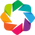

In [1]:
import icepyx as ipx

In [2]:
ipx.__version__

'0.8.2.dev113+g4b7ed93.d20240104'

We will start the way we often do: by creating an icepyx Query object.

In [3]:
short_name = 'ATL03'
spatial_extent = [-45, 58, -35, 75]
date_range = ['2019-11-30','2019-11-30']

In [5]:
!pip install -e ~/icepyx

Obtaining file:///home/jovyan/icepyx
  Preparing metadata (setup.py) ... done
  Attempting uninstall: icepyx
    Found existing installation: icepyx 0.8.2.dev112+g5b91c85
    Uninstalling icepyx-0.8.2.dev112+g5b91c85:
      Successfully uninstalled icepyx-0.8.2.dev112+g5b91c85
  Running setup.py develop for icepyx


In [4]:
reg = ipx.Query(short_name, spatial_extent, date_range)

### Get the granule s3 urls

With this query object you can get a list of available granules. This function returns a list containing the list of the granule IDs and a list of the corresponding urls. Use `cloud=True` to get the needed s3 urls.

In [5]:
gran_ids = reg.avail_granules(ids=True, cloud=True)
gran_ids

[['ATL03_20191130112041_09860505_006_01.h5',
  'ATL03_20191130220138_09930502_006_01.h5',
  'ATL03_20191130221008_09930503_006_01.h5'],
 ['s3://nsidc-cumulus-prod-protected/ATLAS/ATL03/006/2019/11/30/ATL03_20191130112041_09860505_006_01.h5',
  's3://nsidc-cumulus-prod-protected/ATLAS/ATL03/006/2019/11/30/ATL03_20191130220138_09930502_006_01.h5',
  's3://nsidc-cumulus-prod-protected/ATLAS/ATL03/006/2019/11/30/ATL03_20191130221008_09930503_006_01.h5']]

## Determining variables of interest

There are several ways to view available variables. One is to use the existing Query object:

In [6]:
reg.order_vars.avail()

Enter your Earthdata Login username:  icepyx_devteam
Enter your Earthdata password:  ········


['ds_surf_type',
 'ds_xyz',
 'ancillary_data/atlas_sdp_gps_epoch',
 'ancillary_data/control',
 'ancillary_data/data_end_utc',
 'ancillary_data/data_start_utc',
 'ancillary_data/end_cycle',
 'ancillary_data/end_delta_time',
 'ancillary_data/end_geoseg',
 'ancillary_data/end_gpssow',
 'ancillary_data/end_gpsweek',
 'ancillary_data/end_orbit',
 'ancillary_data/end_region',
 'ancillary_data/end_rgt',
 'ancillary_data/granule_end_utc',
 'ancillary_data/granule_start_utc',
 'ancillary_data/release',
 'ancillary_data/start_cycle',
 'ancillary_data/start_delta_time',
 'ancillary_data/start_geoseg',
 'ancillary_data/start_gpssow',
 'ancillary_data/start_gpsweek',
 'ancillary_data/start_orbit',
 'ancillary_data/start_region',
 'ancillary_data/start_rgt',
 'ancillary_data/version',
 'ancillary_data/altimetry/atl03_pad',
 'ancillary_data/altimetry/band_tol',
 'ancillary_data/altimetry/min_full_sat',
 'ancillary_data/altimetry/min_knn',
 'ancillary_data/altimetry/min_near_sat',
 'ancillary_data/alt

Another way is to use the variables module:

In [7]:
ipx.Variables(product=short_name).avail()

['ds_surf_type',
 'ds_xyz',
 'ancillary_data/atlas_sdp_gps_epoch',
 'ancillary_data/control',
 'ancillary_data/data_end_utc',
 'ancillary_data/data_start_utc',
 'ancillary_data/end_cycle',
 'ancillary_data/end_delta_time',
 'ancillary_data/end_geoseg',
 'ancillary_data/end_gpssow',
 'ancillary_data/end_gpsweek',
 'ancillary_data/end_orbit',
 'ancillary_data/end_region',
 'ancillary_data/end_rgt',
 'ancillary_data/granule_end_utc',
 'ancillary_data/granule_start_utc',
 'ancillary_data/release',
 'ancillary_data/start_cycle',
 'ancillary_data/start_delta_time',
 'ancillary_data/start_geoseg',
 'ancillary_data/start_gpssow',
 'ancillary_data/start_gpsweek',
 'ancillary_data/start_orbit',
 'ancillary_data/start_region',
 'ancillary_data/start_rgt',
 'ancillary_data/version',
 'ancillary_data/altimetry/atl03_pad',
 'ancillary_data/altimetry/band_tol',
 'ancillary_data/altimetry/min_full_sat',
 'ancillary_data/altimetry/min_knn',
 'ancillary_data/altimetry/min_near_sat',
 'ancillary_data/alt

We can also do this using a specific s3 filepath from the Query object:

In [8]:
ipx.Variables(path=gran_ids[1][0]).avail()

['ds_surf_type',
 'ds_xyz',
 'ancillary_data/atlas_sdp_gps_epoch',
 'ancillary_data/control',
 'ancillary_data/data_end_utc',
 'ancillary_data/data_start_utc',
 'ancillary_data/end_cycle',
 'ancillary_data/end_delta_time',
 'ancillary_data/end_geoseg',
 'ancillary_data/end_gpssow',
 'ancillary_data/end_gpsweek',
 'ancillary_data/end_orbit',
 'ancillary_data/end_region',
 'ancillary_data/end_rgt',
 'ancillary_data/granule_end_utc',
 'ancillary_data/granule_start_utc',
 'ancillary_data/release',
 'ancillary_data/start_cycle',
 'ancillary_data/start_delta_time',
 'ancillary_data/start_geoseg',
 'ancillary_data/start_gpssow',
 'ancillary_data/start_gpsweek',
 'ancillary_data/start_orbit',
 'ancillary_data/start_region',
 'ancillary_data/start_rgt',
 'ancillary_data/version',
 'ancillary_data/altimetry/atl03_pad',
 'ancillary_data/altimetry/band_tol',
 'ancillary_data/altimetry/min_full_sat',
 'ancillary_data/altimetry/min_knn',
 'ancillary_data/altimetry/min_near_sat',
 'ancillary_data/alt

From any of these methods we can see that `h_ph` is a variable for this data product, so we will read that variable in the next step.

#### A Note on listing variables using s3 urls

We can use the Variables module with an s3 url to explore available data variables the same way we do with local files. An important difference, however, is how the available variables list is created. When reading a local file the variables module will traverse the entire file and search for variables that are present in that file. This method it too time intensive with the s3 data, so instead the the product / version of the data product is read from the file and all possible variables associated with that product/version are reporting as available. As long as you are using the NSIDC provided s3 paths provided via Earthdata search and the Query object these lists will be the same.

#### A Note on authentication

Notice that accessing cloud data requires two layers of authentication: 1) authenticating with your Earthdata Login 2) authenticating for cloud access. These both happen behind the scenes, without the need for users to provide any explicit commands.

Icepyx uses earthaccess to generate your s3 data access token, which will be valid for *one* hour. Icepyx will also renew the token for you after an hour, so if viewing your token over the course of several hours you may notice the values will change.

If you do want to see your s3 credentials, you can access them using:

In [9]:
# uncommenting the line below will print your temporary aws login credentials
# reg.s3login_credentials

```{admonition} Important Authentication Update
Previously, icepyx required you to explicitly use the `.earthdata_login()` function to login. Running this function is no longer required, as icepyx will call the login function as needed. The user will still need to provide their credentials using one of the three methods decribed in the [ICESat-2 Data Access Notebook](https://icepyx.readthedocs.io/en/latest/example_notebooks/IS2_data_access.html) example. The `.earthdata_login()` function is still available for backwards compatibility.

If you are unable to remove `earthdata_login()` calls from your workflow, note that certain deprecated inputs, such as `earthdata_uid` and `email`, will now result in a deprecation err `region_a.earthdata_login(earthdata_uid, email)` becomes `region_a.earthdata_login()`
```

## Choose a data file and access the data

**Note: If you get a PermissionDenied Error when trying to read in the data, you may not be sending your request from an AWS hub in us-west2. We're currently working on how to alert users if they will not be able to access ICESat-2 data in the cloud for this reason**

We are ready to read our data! We do this by creating a reader object and using the s3 url returned from the Query object.

In [10]:
# the first index, [1], gets us into the list of s3 urls
# the second index, [0], gets us the first entry in that list.
s3url = gran_ids[1][0]
# s3url =  's3://nsidc-cumulus-prod-protected/ATLAS/ATL03/004/2019/11/30/ATL03_20191130221008_09930503_004_01.h5'

Create the Read object

In [ ]:
reader = ipx.Read(gran_ids[1], product="ATL03")

This reader object gives us yet another way to view available variables.

In [12]:
reader.vars.avail()

['ds_surf_type',
 'ds_xyz',
 'ancillary_data/atlas_sdp_gps_epoch',
 'ancillary_data/control',
 'ancillary_data/data_end_utc',
 'ancillary_data/data_start_utc',
 'ancillary_data/end_cycle',
 'ancillary_data/end_delta_time',
 'ancillary_data/end_geoseg',
 'ancillary_data/end_gpssow',
 'ancillary_data/end_gpsweek',
 'ancillary_data/end_orbit',
 'ancillary_data/end_region',
 'ancillary_data/end_rgt',
 'ancillary_data/granule_end_utc',
 'ancillary_data/granule_start_utc',
 'ancillary_data/release',
 'ancillary_data/start_cycle',
 'ancillary_data/start_delta_time',
 'ancillary_data/start_geoseg',
 'ancillary_data/start_gpssow',
 'ancillary_data/start_gpsweek',
 'ancillary_data/start_orbit',
 'ancillary_data/start_region',
 'ancillary_data/start_rgt',
 'ancillary_data/version',
 'ancillary_data/altimetry/atl03_pad',
 'ancillary_data/altimetry/band_tol',
 'ancillary_data/altimetry/min_full_sat',
 'ancillary_data/altimetry/min_knn',
 'ancillary_data/altimetry/min_near_sat',
 'ancillary_data/alt

Next, we append our desired variable to the `wanted_vars` list:

In [13]:
reader.vars.append(var_list=['h_ph'])

Finally, we load the data

In [14]:
%%time

# This may take 5-10 minutes
reader.load()

CPU times: user 2min 34s, sys: 34 s, total: 3min 8s
Wall time: 6min 53s


<xarray.Dataset>
Dimensions:              (gran_idx: 1, photon_idx: 43228610, spot: 6)
Coordinates:
  * gran_idx             (gran_idx) float64 9.86e+04
  * photon_idx           (photon_idx) int64 0 1 2 ... 43228607 43228608 43228609
  * spot                 (spot) uint8 1 2 3 4 5 6
    source_file          (gran_idx) object <File-like object S3FileSystem, ns...
    delta_time           (photon_idx) datetime64[ns] 2019-11-30T11:20:41.0182...
Data variables:
    sc_orient            (gran_idx) int8 1
    cycle_number         (gran_idx) int8 5
    rgt                  (gran_idx) int16 986
    atlas_sdp_gps_epoch  (gran_idx) datetime64[ns] 2018-01-01T00:00:18
    data_start_utc       (gran_idx) datetime64[ns] 2019-11-30T11:20:40.986495
    data_end_utc         (gran_idx) datetime64[ns] 2019-11-30T11:26:06.436402
    h_ph                 (spot, gran_idx, photon_idx) float32 nan nan ... nan
    gt                   (gran_idx, spot) <U4 'gt3r' 'gt3l' ... 'gt1r' 'gt1l'
Attributes:
    data_product:  ATL03
    Description:   Contains arrays of the parameters for each received photon.
    data_rate:     Data are stored at the photon detection rate.

### Some important caveats

While the cloud data reading is functional within icepyx, it is very slow. Approximate timing shows it takes ~6 minutes of load time per variable per file from s3. Because of this you will recieve a warning if you try to load either more than three variables or two files at once.

The slow load speed is a demonstration of the many steps involved in making cloud data actionable - the data supply chain needs optimized source data, efficient low level data readers, and high level libraries which are enabled to use the fastest low level data readers. Not all of these pieces fully developed right now, but the progress being made it exciting and there is lots of room for contribution!

#### Credits
* notebook by: Jessica Scheick and Rachel Wegener